# Gaussian Deconvolution for FTIR
Andrew E. Ashmar | Last Updated 02/13/2023

This notebook demonstrates the concept of Gaussian deconvolution to isolate specific peaks in FTIR spectra. This tutorial requires the use of the `pandas`, `matplotlib`, and `scipy` Python packages, which should be preinstalled if this notebook is opened in Google Colab.

## Importing Required Packages & Data
First, we need to import the datafile. You can modify the file name/path by changing the `filename` variable below. Make sure your data file only contains two columns, one labeled "wavelength" and one labeled "transmittance".

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as sciopt

# Importing demo dataset
filename = "FTIR-Sample-Data.csv"
data = pd.read_csv(filename)
amide1 = data.loc[data["wavelength"].between(1600, 1700, inclusive="both")]

## Mathematical Background
Any given spectral dataset contains a collection of signals or "peaks", as can be seen in the FTIR spectrum shown below. Each peak represents a unique chemical signature, such as a specific bond type (ex. C-H vs. C-N) or other molecular feature (ex. $\beta$-sheet vs. $\alpha$-helix in proteins). While the wavelengths of signals for differnt chemical features are readily available in literature, it can be difficult to distinguish neighboring signals from one another. We can use a technique called **deconvolution** to separate individual peaks, which is useful in obtaining quantitative data from spectroscopic experiments.

Before starting spectral deconvolution, however, we must first normalize the baseline of the spectrum. This process is called **baseline correction**. First, we will plot the Amide I region of the FTIR spectrum (from 1600 $\text{cm}^{-1}$ to 1700 $\text{cm}^{-1}$) to see what the spectrum looks like before baseline correction.

In [12]:
plt.style.use("seaborn-v0_8-muted")
plt.plot(amide1["wavelength"], amide1["transmittance"])
plt.xlabel("Wavelength (cm$^{-1}$)")
plt.ylabel("% Transmittance")

Text(33.722222222222214, 0.5, '% Transmittance')

We will start by establishing the new baseline as the straight line between the points at 1600 $\text{cm}^{-1}$ and 1700 $\text{cm}^{-1}$. We can do this using the `numpy.polynomial.polynomial.fit()` command.

In [13]:
baseWave = [1700, 1600]
baseTrans = [
    amide1["transmittance"].head(1).squeeze(),
    amide1["transmittance"].tail(1).squeeze(),
]  # Extracting the transmittance at the start and end of the amide I peak
baseFit = np.polynomial.polynomial.polyfit(
    baseWave, baseTrans, 1
)  # Fitting a line between points

In [14]:
# Interpolating the baseline and correcting spectral data
baseInterp = baseFit[0] + (amide1["wavelength"] * baseFit[1])
correction = amide1["transmittance"].max() - baseInterp
new = amide1["transmittance"] + correction

# Plotting the original and corrected data
plt.plot(amide1["wavelength"], amide1["transmittance"])
plt.plot(amide1["wavelength"], new)
plt.legend(["Original Data", "Corrected Data"])
plt.xlabel("Wavelength (cm$^{-1}$)")
plt.ylabel("% Transmittance")

Text(46.972222222222214, 0.5, '% Transmittance')

The shape of individual peaks in a spectrogram depends on the spectroscopic method. FTIR signals are best modeled via [Gaussian functions](https://en.wikipedia.org/wiki/Gaussian_function), while techniques such as NMR and X-Ray scattering form Lorentzian and Voigt lineshapes, respectively. While this tutorial focuses on the deconvolution of FTIR spectra via Gaussian curve fitting, this method can be adapted for other lineshapes.

The data for an individual spectral peak can be fitted to the equation: $g(x) = \frac{1}{\sigma \sqrt{2\pi}} e^{\frac{-1(x-\mu)^2}{2\sigma^2}}$. First, we will turn this equation into a Python function:

In [15]:
def gaussian1(x, amp1, mu1, sigma1):
    # amp = amplitude
    # mu = center (mean) of the peak
    # sigma = standard deviation
    return (
        amp1
        * (1 / (sigma1 * (np.sqrt(2 * np.pi))))
        * (np.exp((-0.5) * (((x - mu1) / sigma1) ** 2)))
    )

The Python function we just created only models one Gaussian peak, however sometimes we may have multiple peaks in a single spectrum. For example, the Amide I region of an FTIR spectrum of a protein contains three peaks of interest. We can modify the above function to account for two or three peaks as shown below:

In [16]:
# Function for fitting two gaussians
def gaussian2(x, amp1, mu1, sigma1, amp2, mu2, sigma2):
    return amp1 * (1 / (sigma1 * (np.sqrt(2 * np.pi)))) * (
        np.exp((-0.5) * (((x - mu1) / sigma1) ** 2))
    ) + amp2 * (1 / (sigma2 * (np.sqrt(2 * np.pi)))) * (
        np.exp((-0.5) * (((x - mu2) / sigma2) ** 2))
    )


# Function for fitting three Gaussian curves
def gaussian3(x, amp1, mu1, sigma1, amp2, mu2, sigma2, amp3, mu3, sigma3):
    return (
        amp1
        * (1 / (sigma1 * (np.sqrt(2 * np.pi))))
        * (np.exp((-0.5) * (((x - mu1) / sigma1) ** 2)))
        + amp2
        * (1 / (sigma2 * (np.sqrt(2 * np.pi))))
        * (np.exp((-0.5) * (((x - mu2) / sigma2) ** 2)))
        + amp3
        * (1 / (sigma3 * (np.sqrt(2 * np.pi))))
        * (np.exp((-0.5) * (((x - mu3) / sigma3) ** 2)))
    )

Now that we have the Gaussian function defined, we can fit our FTIR data to the Gaussians! To do this, we will need to establish initial guesses of the amplitude, mean, and standard deviation of each Gaussian peak. The mean (values in `mus`) can be set to the tabulated wavelengths for each peak of interest, while the other parameters should be okay if left as-is. You can play around with these guesses to fine-tune your model if desired.

In [17]:
# Converting to '% absorbance' instead of '% transmittance'
amide1.loc[:, "absorbance"] = new.max() - new

# Splitting dataframe into variables for convenience
wave = amide1["wavelength"]
absorbance = amide1["absorbance"]

# Establishing best initial guesses for fit parameters
amps = [200, 200, 100]
mus = [1633, 1654, 1684]
sigmas = [10, 10, 5]

# Fitting the data to the Gaussian function
optVals, pcov = sciopt.curve_fit(
    gaussian3,
    wave,
    absorbance,
    p0=[
        amps[0],
        mus[0],
        sigmas[0],
        amps[1],
        mus[1],
        sigmas[1],
        amps[2],
        mus[2],
        sigmas[2],
    ],
    bounds=(
        [0, 1623, 0, 0, 1648, 0, 0, 1674, 0],
        [np.inf, 1641, np.inf, np.inf, 1657, np.inf, np.inf, 1695, np.inf],
    ),
    maxfev=100000,
)
1674

perr = np.sqrt(np.diag(pcov))  # Computing error in fit parameters

# Saving fit parameters to variables for convenience
valsPeak1 = optVals[0:3]
valsPeak2 = optVals[3:6]
valsPeak3 = optVals[6:9]


# print("Peak 1:" + str(valsPeak1))
# print("Peak 2:" + str(valsPeak2))
# print("Peak 3:" + str(valsPeak3))

# print("Peak 1 Error:" + str(perr[0:3]))
# print("Peak 2 Error:" + str(perr[3:6]))
# print("Peak 3 Error:" + str(perr[6:9]))

/var/folders/jd/f9fr68290s50fw4dlfh7844r0000gn/T/ipykernel_24647/2100792754.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  amide1.loc[:, "absorbance"] = new.max() - new


Now we should have a parameters for our Gaussian curves! Yay! We can now plot each Gaussian function to see how it looks when overlaid with the original FTIR spectrum.

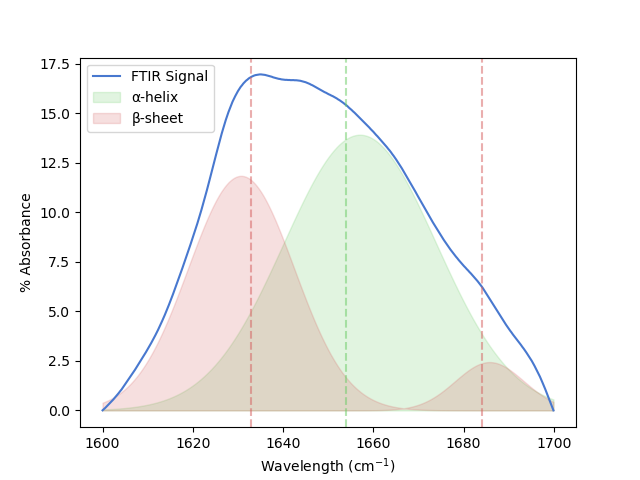

In [18]:
%matplotlib widget
# Creating y-values for the fit curves based on fit parameters
peak1 = gaussian1(wave, *valsPeak1)
peak2 = gaussian1(wave, *valsPeak2)
peak3 = gaussian1(wave, *valsPeak3)

# Generating Plots
finalPlot = plt.figure()
plt.plot(wave, absorbance, figure=finalPlot, color="C0")
plt.fill_between(x=wave, y1=peak2, figure=finalPlot, alpha=0.2, color="C1")
plt.fill_between(x=wave, y1=peak1, y2=peak3, figure=finalPlot, alpha=0.2, color="C2")

# Plot styling
plt.xlabel("Wavelength (cm$^{-1}$)")
plt.ylabel("% Absorbance")
plt.legend(["FTIR Signal", 'α-helix', "β-sheet"])

plt.axvline(1654, color='C1', linestyle='--', alpha=0.5, linewidth=1.5)
plt.axvline(1633, color='C2', linestyle='--', alpha=0.5, linewidth=1.5)
plt.axvline(1684, color='C2', linestyle='--', alpha=0.5, linewidth=1.5)

Does the fit look good? If not, go back and try to modify your initial guesses for the fit parameters to get a better fit. When it does look good, then we can move on to quantifying the area under each peak! We can do this using the `numpy.trapz()` function and some simple arithmetic.

In [19]:
alpha = np.trapz(y=peak2, x=wave)
beta = np.trapz(y=peak1, x=wave) + np.trapz(y=peak3, x=wave)
total = alpha + beta

alphaPercent = alpha / total * 100
betaPercent = beta / total * 100

print("α-helix: {:.2f}%".format(alphaPercent))
print("β-sheet: {:.2f}%".format(betaPercent))

α-helix: 59.91%
β-sheet: 40.09%


The last step is to save our baseline-corrected data to a .csv file so that we can compare it with other spectra. You can modify the path below as needed to change where the .csv file is saved.

In [20]:
exportData = amide1[["wavelength", "absorbance"]]
# newPath = (
# Put the path to your desired output file here
# )
# exportData.to_csv(newPath, index=False)